In [ ]:
!pip install pycaret
# !pip install numpy==1.23.5


In [ ]:
# check python version
!python --version

Python 3.11.11


In [ ]:
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, confusion_matrix
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.feature_selection import f_classif
from scipy.stats.contingency import association

from matplotlib.lines import Line2D

import joblib
import json
from pycaret.classification import *



In [187]:
# Call utility file containing all functions

%load_ext autoreload
%autoreload 2
import Utility as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
diabetic_df = pd.read_csv('diabetic_data.csv')

print(diabetic_df.shape)

diabetic_df.head(5)

(101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [11]:
# Check outcome variable

print(diabetic_df.shape)

diabetic_df['readmitted'].value_counts()


(101766, 50)


readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

# **1. Exploratory Data Analysis (EDA)**

#### Visualize and Handle Missing Data

In [29]:
diabetic_df.replace('?', pd.NA, inplace=True) # missing values for object columns are labelled as "?", replace with NA
diabetic_df.replace('Unknown/Invalid', pd.NA, inplace=True) # replace unknown gender with NA

# Print the number of missing values for
na_counts = diabetic_df.isna().sum()
print(na_counts)

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          3
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

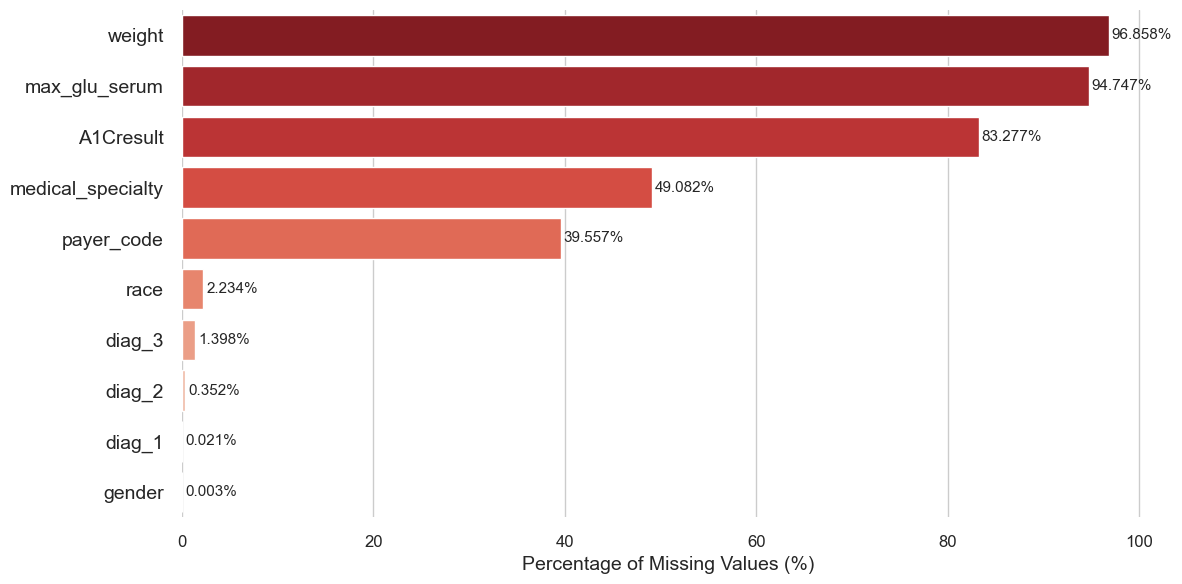

In [33]:
# Plot percentage of missing data for all features
na_percentage = (na_counts / len(diabetic_df)) * 100

na_percentage = na_percentage[na_percentage > 0]

# Create DataFrame with only features containing missing values
na_df = pd.DataFrame({
    "Feature": na_percentage.index,
    "Missing Percentage": na_percentage.values
}).sort_values(by="Missing Percentage", ascending=False)

# Plotting
plt.figure(figsize=(12, max(6, 0.4 * len(na_df))))

ax = sns.barplot(
    y="Feature",
    x="Missing Percentage",
    data=na_df,
    palette="Reds_r"
)

# Add percentage labels at the end of each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(
        width + 0.3,                  # slightly offset to the right of bar
        p.get_y() + p.get_height() / 2,
        f'{width:.3f}%',              # formatted percentage text
        va='center', 
        fontsize=11
    )

# Aesthetic improvements
plt.xlabel("Percentage of Missing Values (%)", fontsize=14)
plt.ylabel("")
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=14)
#plt.title("Missing Data by Feature (Features with Missing Values Only)", fontsize=16)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


In [15]:
# Remove the variables that contain more than 30% of missing values
cols_missing_val = na_df[na_df['Missing Percentage'] > 30]['Feature']
# print(cols_missing_val)
diabetic_df_filtered = diabetic_df.drop(columns=cols_missing_val).copy()

# Remove the variables that contains the same values - so they do not provide useful discriminatory information
diabetic_df_filtered = diabetic_df_filtered.drop(['citoglipton', 'examide'], axis = 1)

# encounter_id and patient_nbr do not carry useful information for re-admission, so we drop them as well
diabetic_df_filtered = diabetic_df_filtered.drop(['encounter_id', 'patient_nbr'], axis = 1)

# For computation, we drop the rest columns with lots of missing values - race
diabetic_df_filtered = diabetic_df_filtered.drop(['race'], axis = 1)

# remove the rows with missing Gender data
diabetic_df_filtered = diabetic_df_filtered.dropna(subset=['gender', 'diag_1', 'diag_2', 'diag_3'])


# Check the selected variables again
na_counts = diabetic_df_filtered.isna().sum()
if na_counts.sum() == 0:
    print("No missing data remaining")
else:
    print("Features with missing values:")
    print(na_counts)

No missing data remaining


### Check Data Type Distribution

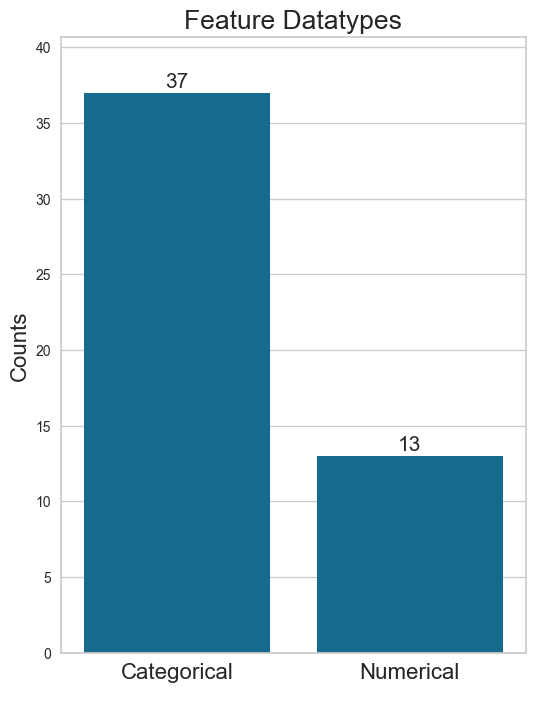

In [16]:
# Check datatype distribution
datatype_counts = diabetic_df.dtypes.value_counts()

# Create mapping
datatype_mapping = {
    'object': 'Categorical',
    'int64': 'Numerical',
    'float64': 'Numerical'
}

# Convert to Series and map
x_labels_series = pd.Series(datatype_counts.index.astype(str))
x_labels_mapped = x_labels_series.map(datatype_mapping)

# Fill unmapped with original labels
x_labels = x_labels_mapped.where(x_labels_mapped.notna(), x_labels_series)

plt.figure(figsize=(6, 8))
ax = sns.barplot(x=x_labels, y=datatype_counts.values)

plt.xlabel(" ")
plt.ylabel("Counts", size = 16)
plt.title("Feature Datatypes", size = 19)
plt.xticks(rotation=0, size = 16)
plt.ylim(0, 37 * 1.1)

# Add counts on top of bars
for p in ax.patches:
    count = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.1,
            f'{count}', ha='center', va='bottom', fontsize=15)

plt.show()

## Check for data imbalance


Readmitted (<30 days): 11250


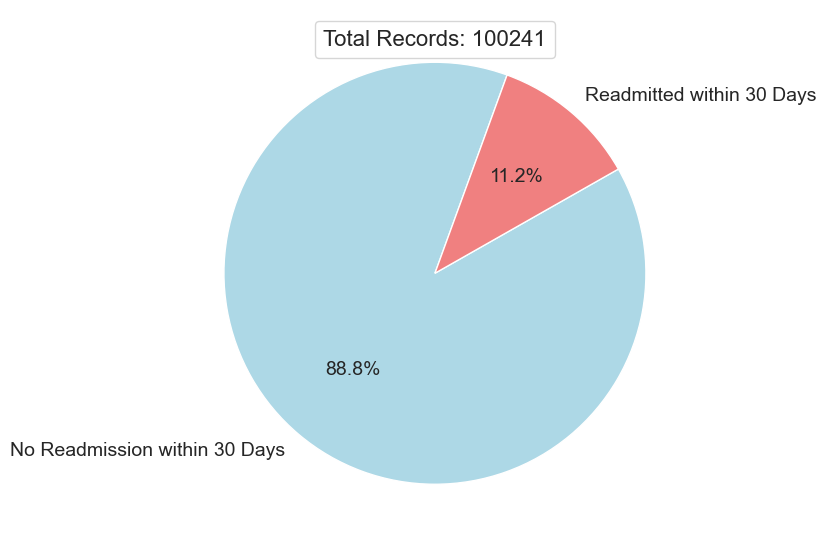

In [ ]:
diabetic_df_filtered['readmitted'] = [1 if x == diabetic_df_filtered['readmitted'][11] else 0 for x in diabetic_df_filtered['readmitted']]
print(f"Readmitted (<30 days): {len(diabetic_df_filtered[diabetic_df_filtered['readmitted'] ==1])}")

readmit_counts = diabetic_df_filtered['readmitted'].value_counts().sort_index()  # ensures 0 then 1 order
labels = ['No Readmission within 30 Days', 'Readmitted within 30 Days']
sizes = [readmit_counts[0], readmit_counts[1]]

colors = ['lightblue', 'lightcoral'] 
# Plot pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=70,
    colors=colors,
    textprops={'fontsize': 14},
    #wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

plt.legend(
    [f"Total Records: {len(diabetic_df_filtered)}"],
    loc='upper center',
    bbox_to_anchor=(0.5, 1),
    fontsize=16,
    frameon=True,
    handlelength=0,
    handletextpad=0
)

# Title
#plt.title("Readmission Distribution (Within 30 Days)", fontsize=16, weight='bold', y=1.05)

plt.tight_layout()
plt.show()

# 2. Feature Engineering



#### 2.1 Feature Encoding

Here we performed encoding for categorical variables

In [ ]:
diabetic_df_encoded = diabetic_df_filtered.copy()

# gender
diabetic_df_encoded['gender'] = diabetic_df_filtered['gender'].map({'Female': 1, 'Male': 0})

# age
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
    '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}
diabetic_df_encoded['age'] = diabetic_df_filtered['age'].map(age_mapping)

# admission_source_id
# 9-Unknown/Invalid: 9, 15, 17, 20, 21
diabetic_df_encoded['admission_source_id']= diabetic_df_encoded['admission_source_id'].apply(lambda x : 9 if x in (15, 17, 20, 21) else x)
# 1-Physician/Clinic Referral:1, 2, 3
diabetic_df_encoded['admission_source_id']= diabetic_df_encoded['admission_source_id'].apply(lambda x : 1 if x in (2,3) else x)
# 4-Transfer from Hospital: 4, 10, 22
diabetic_df_encoded['admission_source_id']= diabetic_df_encoded['admission_source_id'].apply(lambda x : 4 if x in (10,22) else x)
# 5-Transfer from Facility:5, 6, 18, 19, 25, 26
diabetic_df_encoded['admission_source_id']= diabetic_df_encoded['admission_source_id'].apply(lambda x : 5 if x in (6, 18, 19, 25, 26) else x)
# 11-Delivery:11, 12, 13, 14
diabetic_df_encoded['admission_source_id']= diabetic_df_encoded['admission_source_id'].apply(lambda x : 11 if x in (12, 13, 14) else x)

# admission_type_id; group Null
diabetic_df_encoded['admission_type_id']=diabetic_df_encoded['admission_type_id'].apply(lambda x : 5 if x in (6,8) else x)
diabetic_df_encoded['admission_type_id']=diabetic_df_encoded['admission_type_id'].apply(lambda x : 1 if x in (1,2) else x)

# discharge_disposition_id
#Discharged Home: 1, 6, 8
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 1 if x in (6,8) else x)
#Uncategorized/Unknown: 18, 25, 26, 12
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 18 if x in (25,26,12) else x)
#Expired:11, 19, 20, 21
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 11 if x in (19,20,21) else x)
#Hospice:13, 14
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 13 if x ==14 else x)
# Discharged/Transferred to Hospital: 2, 9, 10, 23, 27, 28, 29
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 2 if x in ( 9, 10, 23, 27, 28, 29) else x)
#Discharged/Transferred to Care Facility: 3, 4, 5, 15, 24
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 3 if x in ( 4, 5, 15, 24) else x)
#Discharged to Outpatient Services:16, 17
diabetic_df_encoded['discharge_disposition_id']=diabetic_df_encoded['discharge_disposition_id'].apply(lambda x : 16 if x ==17 else x)

# ENCODE MEDICATION BY TYPE
medication_columns = [
    "metformin", "repaglinide", "nateglinide", "chlorpropamide",
    "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone",
    "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide",
     "insulin", "glyburide-metformin", "glipizide-metformin",
    "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"
]
diabetic_df_encoded[medication_columns] = diabetic_df_filtered[medication_columns].map(
    lambda x: 0 if x == 'Down' else 1 if x == 'No' else 2 if x == 'Steady' else 3
)

# change of medications
diabetic_df_encoded['change'] = diabetic_df_filtered['change'].map({'Ch': 1, 'No':0})

# prescribed diabetes medications
diabetic_df_encoded['diabetesMed'] = diabetic_df_filtered['diabetesMed'].map({'No':0, 'Yes':1})

# readmitted: encoded in EDA

In [35]:
# all three diag features have more than 800 values unique we are grouping them based on ICD-9 codes
# https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9

diag1_list=[]
diag2_list=[]
diag3_list=[]
# This function, diag_cluster, takes a column 'col' and a list 'diag_list' as inputs.
# It iterates through each value in the 'col' column of the DataFrame 'df' and assigns a cluster value based on certain conditions.
# The resulting cluster values are appended to the 'diag_list'.

def diag_cluster(col, diag_list):
    for x in diabetic_df_encoded[col]:
        # If the value in the 'col' column contains 'V' or 'E', it is assigned a cluster value of 18.
        if 'V' in x or 'E' in x:
            diag_list.append(18)
            continue
        # The following conditions assign cluster values based on specific ranges of float values.
        elif 1 <= float(x) <= 139.9:
            diag_list.append(1)
        elif 140 <= float(x) <= 239.9:
            diag_list.append(2)
        elif 240 <= float(x) <= 279.9:
            diag_list.append(3)
        elif 280 <= float(x) <= 289.9:
            diag_list.append(4)
        elif 290 <= float(x) <= 319.9:
            diag_list.append(5)
        elif 320 <= float(x) <= 389.9:
            diag_list.append(6)
        elif 390 <= float(x) <= 459.9:
            diag_list.append(7)
        elif 460 <= float(x) <= 519.9:
            diag_list.append(8)
        elif 520 <= float(x) <= 579.9:
            diag_list.append(9)
        elif 580 <= float(x) <= 629.9:
            diag_list.append(10)
        elif 630 <= float(x) <= 679.9:
            diag_list.append(11)
        elif 680 <= float(x) <= 709.9:
            diag_list.append(12)
        elif 710 <= float(x) <= 739.9:
            diag_list.append(13)
        elif 740 <= float(x) <= 759.9:
            diag_list.append(14)
        elif 760 <= float(x) <= 779.9:
            diag_list.append(15)
        elif 780 <= float(x) <= 799.9:
            diag_list.append(16)
        elif 800 <= float(x) <= 999.9:
            diag_list.append(17)

diag_cluster('diag_1',diag1_list)
diag_cluster('diag_2',diag2_list)
diag_cluster('diag_3',diag3_list)
diabetic_df_encoded['diag_1']=diag1_list
diabetic_df_encoded['diag_2']=diag2_list
diabetic_df_encoded['diag_3']=diag3_list

In [36]:
diabetic_df_encoded

,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,1,15,1,1,7,3,59,0,18,0,...,1,3,1,1,1,1,1,1,1,0
2,1,25,1,1,7,2,11,5,13,2,...,1,1,1,1,1,1,1,0,1,0
3,0,35,1,1,7,2,44,1,16,0,...,1,3,1,1,1,1,1,1,1,0
4,0,45,1,1,7,1,51,0,8,0,...,1,2,1,1,1,1,1,1,1,0
5,0,55,1,1,1,3,31,6,16,0,...,1,2,1,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,0,75,1,3,7,3,51,0,16,0,...,1,0,1,1,1,1,1,1,1,0
101762,1,85,1,3,5,5,33,3,18,0,...,1,2,1,1,1,1,1,0,1,0
101763,0,75,1,1,7,1,53,0,9,1,...,1,0,1,1,1,1,1,1,1,0
101764,1,85,1,3,7,10,45,2,21,0,...,1,3,1,1,1,1,1,1,1,0


##### 2.1.1 One-hot Encoding

In addition, we performed one-hot encoding for categorical features in order to compare and evaluate the encoding techniques on model performance

In [48]:
cat_cols = ['gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
            'diag_1', 'diag_2', 'diag_3',  # include diag1/2/3
            'metformin', 'repaglinide', 'nateglinide','chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
            'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
            'miglitol', 'troglitazone', 'tolazamide', 'insulin',
            'glyburide-metformin', 'glipizide-metformin',
            'glimepiride-pioglitazone', 'metformin-rosiglitazone',
            'metformin-pioglitazone', 'change', 'diabetesMed']

diabetic_df_one_hot = pd.get_dummies(diabetic_df_encoded, columns=cat_cols
                                     , drop_first=True
                                     )
diabetic_df_one_hot = diabetic_df_one_hot.map(lambda x: 0 if x == False else 1 if x == True else x)

# comment out if diag1/2/3 is included in cat_cols
# diabetic_df_one_hot = diabetic_df_one_hot.drop(columns=['diag_1', 'diag_2', 'diag_3'])

one_hot_cat_list = diabetic_df_one_hot.iloc[:,10:].columns.to_list()

### 2.2 Feature EDA

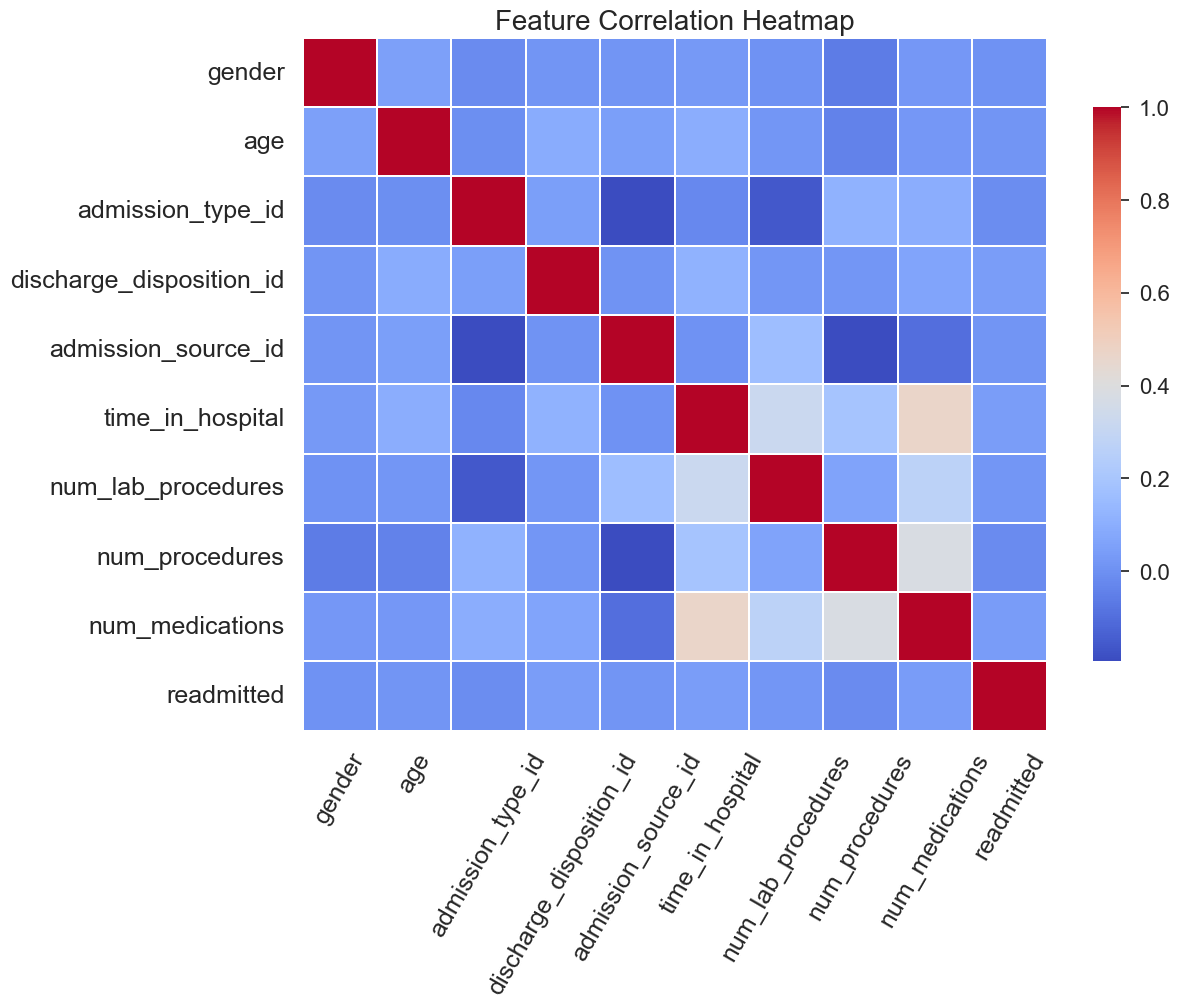

In [ ]:
# Plot feature correlation heatmap

# drop all non-numeric columns (race, admission type, discharge type, etc)
num_features = diabetic_df_encoded.iloc[:, :9].columns.to_list()
num_features = num_features + ['readmitted']

plt.figure(figsize=(12, 9))

# Plot heatmap and explicitly assign cbar
heatmap = sns.heatmap(diabetic_df_encoded[num_features].corr(), cmap="coolwarm", linewidths=0.2, cbar_kws={'shrink': 0.8})

plt.title("Feature Correlation Heatmap", size=20)
plt.xticks(rotation=60, size=18)
plt.yticks(rotation=0, size=18)

colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=16)  # Change text size

plt.show()

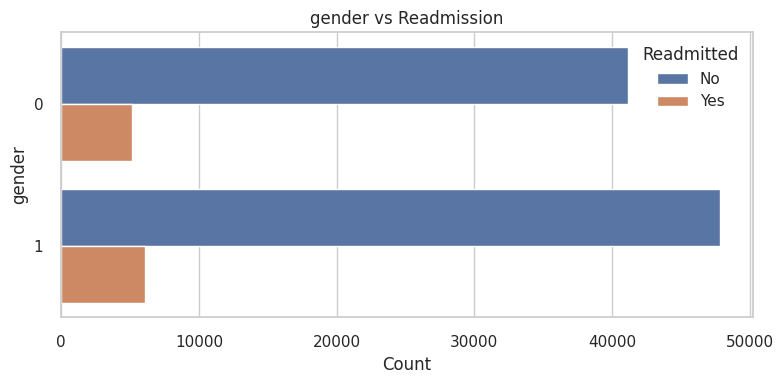

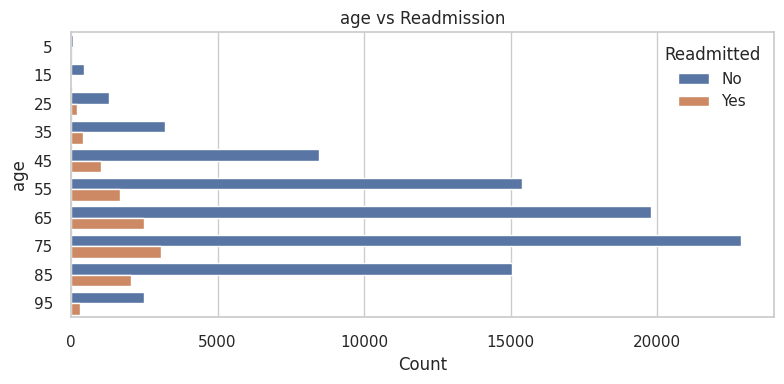

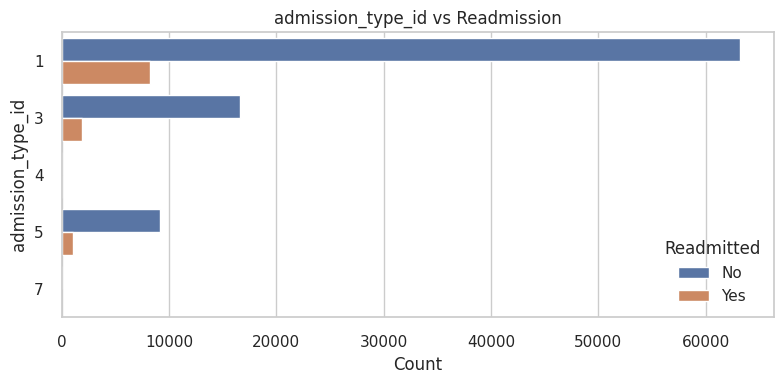

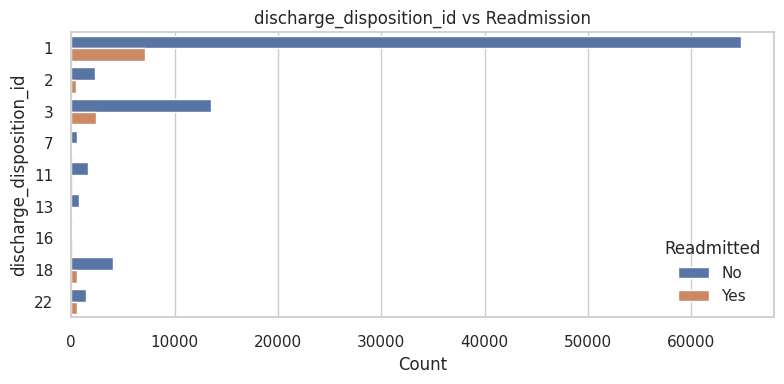

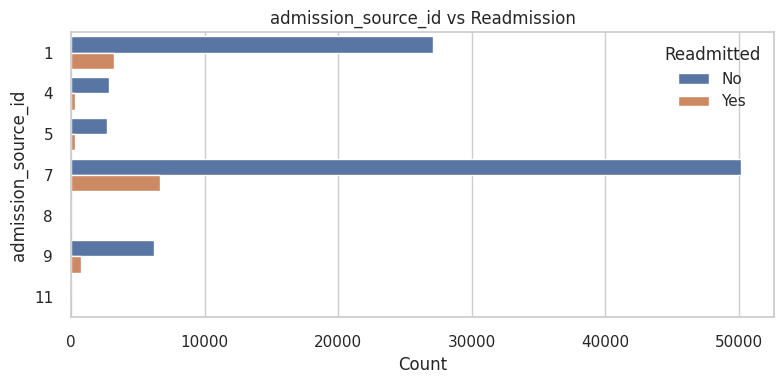

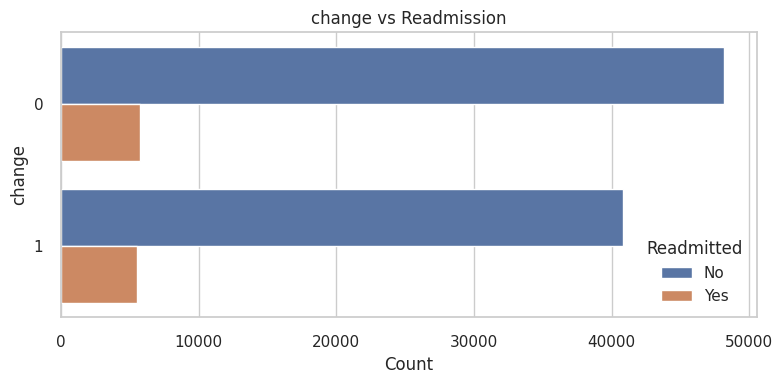

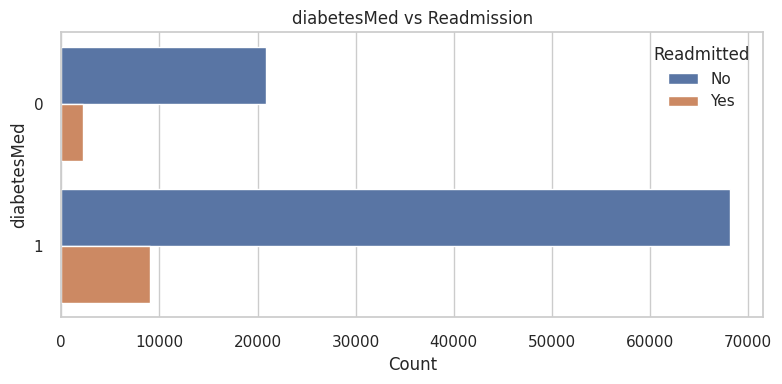

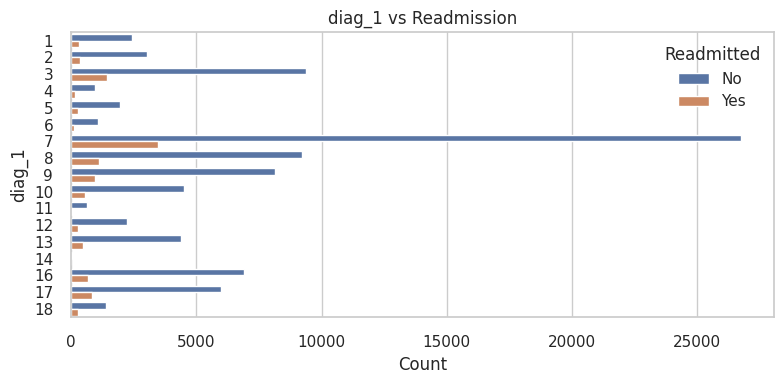

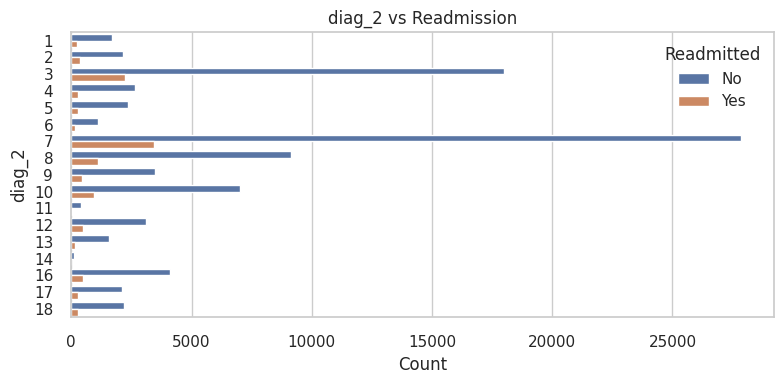

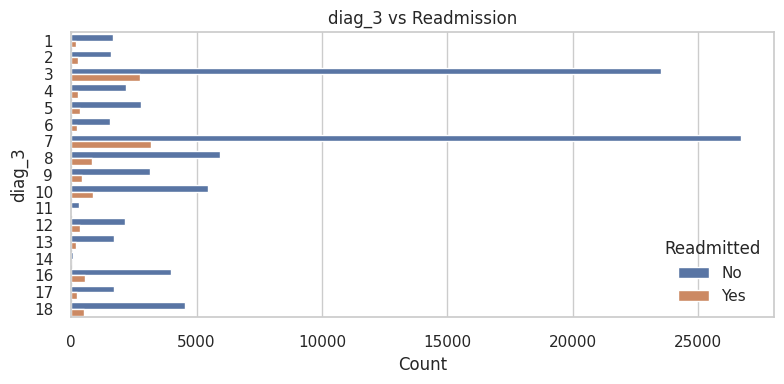

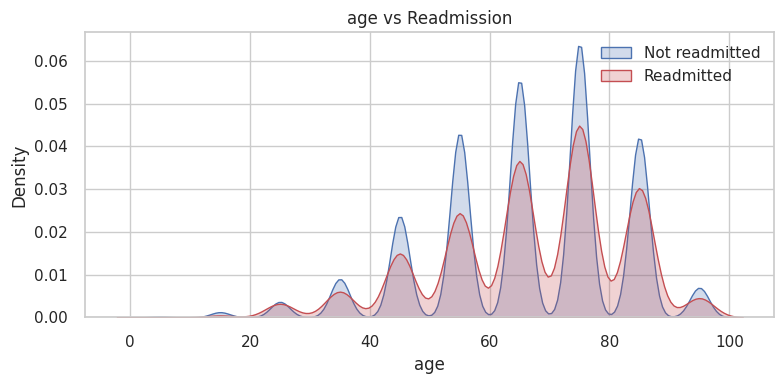

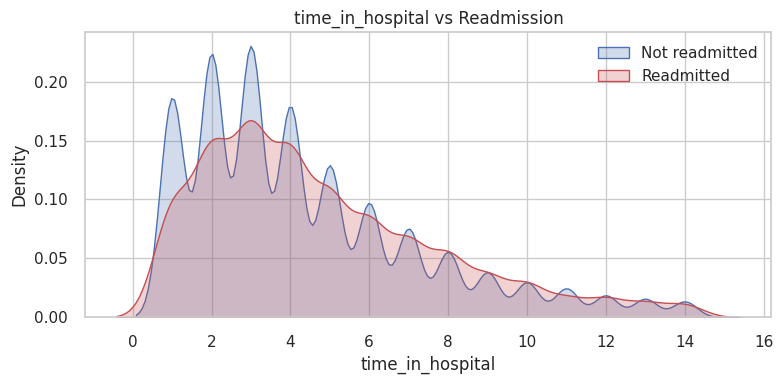

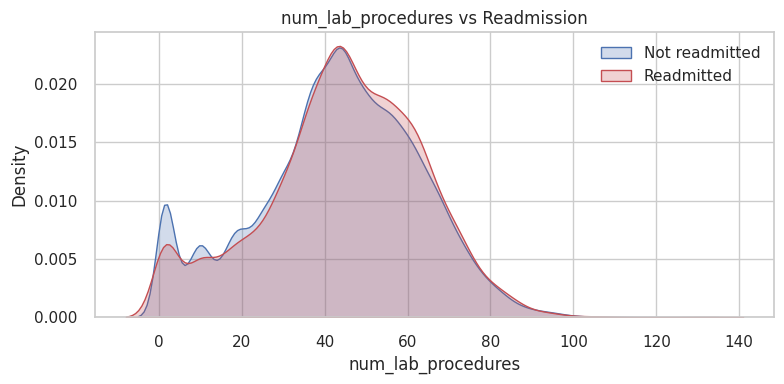

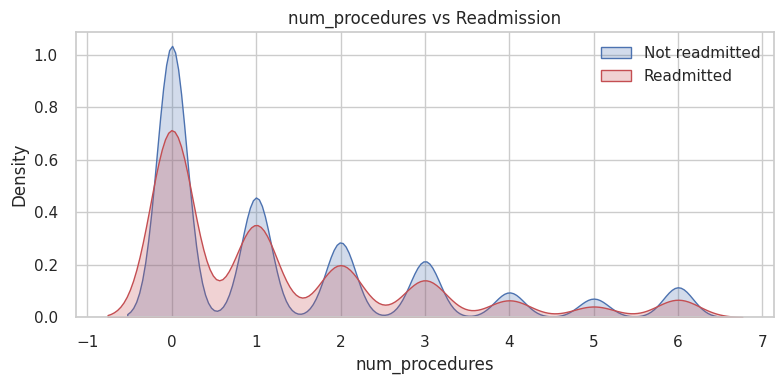

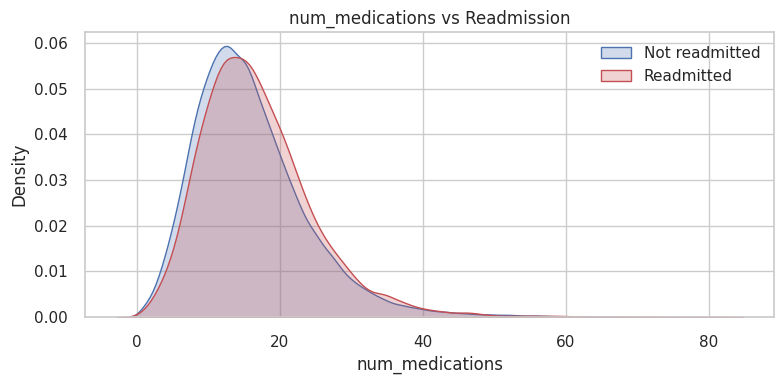

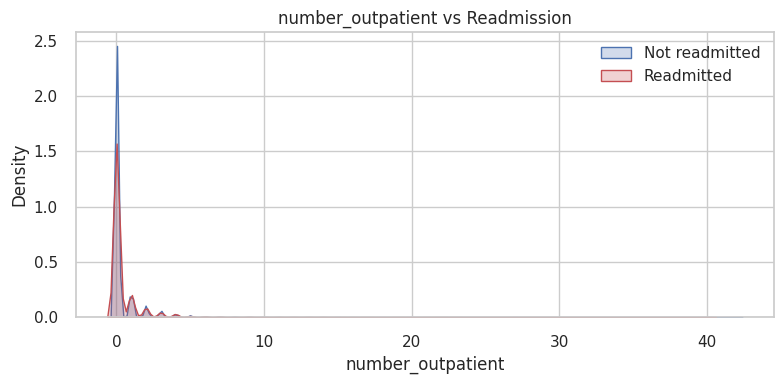

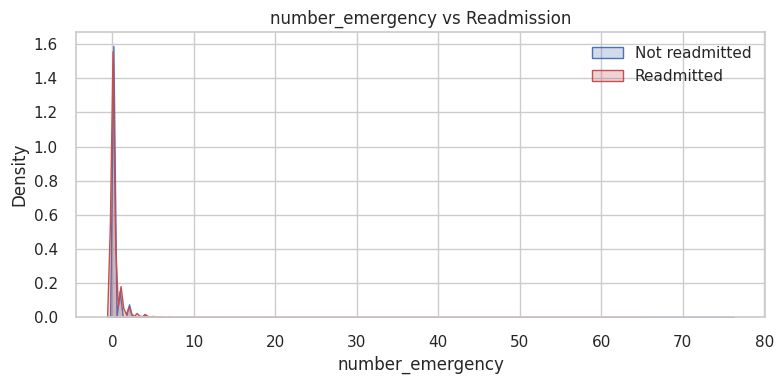

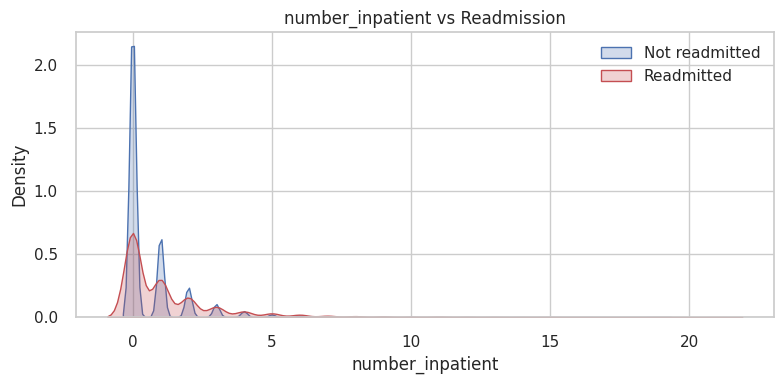

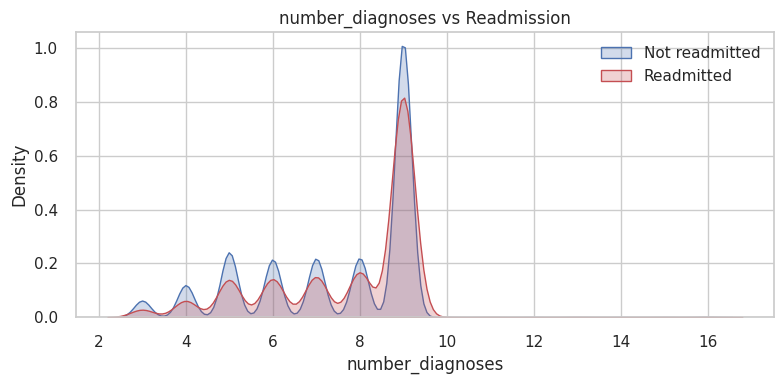

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Set global plot style
sns.set(style="whitegrid")

categorical_features = [
    'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'change', 'diabetesMed', 'diag_1', 'diag_2', 'diag_3'
]

numerical_features = ['age',
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'
]

for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=diabetic_df_encoded[feature], hue=diabetic_df_encoded['readmitted'])
    plt.title(f'{feature} vs Readmission')
    plt.xlabel('Count')
    plt.ylabel(feature)
    plt.legend(title='Readmitted', labels=['No', 'Yes'])
    plt.tight_layout()
    plt.show()

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(
        diabetic_df_encoded.loc[diabetic_df_encoded['readmitted'] == 0, feature],
        shade=True, color='b', label='Not readmitted'
    )
    sns.kdeplot(
        diabetic_df_encoded.loc[diabetic_df_encoded['readmitted'] == 1, feature],
        shade=True, color='r', label='Readmitted'
    )
    plt.title(f'{feature} vs Readmission')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


# 3. Selecting Best Preprocessing Techniques Based on Model Performance

## Train-val-test split

In [ ]:
# train test split for diabetic_df_encode
X_train_encoded, X_val_encoded, X_test_encoded, y_train_encoded, y_val_encoded, y_test_encoded = fn.split_data(diabetic_df_encoded)

# train test split for diabetic_df_one_hot
X_train_onehot, X_val_onehot, X_test_onehot, y_train_onehot, y_val_onehot, y_test_onehot = fn.split_data(diabetic_df_one_hot)


## 3.1 Test Encoding Method on Classification performance

Use LogReg as baseline model (class_weight = "balanced")

#### Baseline Function for Log Reg

### Test One-Hot Encoding

In [188]:
# Balanced, ONEHOT
best_log_reg, log_reg_metrics = fn.train_log_reg(
    X_train_onehot, y_train_onehot, X_val_onehot, y_val_onehot, evaluate_model, class_weight = 'balanced', model_name="Logistic Regression, One-hot"
)

log_reg_metrics

{'Model': 'Logistic Regression, One-hot',
 'Accuracy': 0.6057110792443419,
 'Precision': 0.16469018677734953,
 'Sensitivity': 0.6172222222222222,
 'Specificity': 0.6042559168480932,
 'F1 Score': 0.2600046805523052,
 'AUROC': 0.6551726088754671,
 'AUPRC': 0.21391298378947732,
 'Threshold': 0.47127195538150324}

### Test Label Encoding

In [189]:
# Balanced, Multi-class Encode
best_log_reg, log_reg_metrics = fn.train_log_reg(
    X_train_encoded, y_train_encoded, X_val_encoded, y_val_encoded, evaluate_model, class_weight = 'balanced', model_name="Logistic Regression, Multi-class encoded"
)

log_reg_metrics

{'Model': 'Logistic Regression, Multi-class encoded',
 'Accuracy': 0.6850177691876053,
 'Precision': 0.17270531400966183,
 'Sensitivity': 0.4766666666666667,
 'Specificity': 0.7113561345600112,
 'F1 Score': 0.25354609929078015,
 'AUROC': 0.6280000936395346,
 'AUPRC': 0.19838755055443014,
 'Threshold': 0.5065975264788173}

### Conclusion: **One Hot** is better
(Higher F1 score)

## 3.2 Reduce skewness of numerical feature 

In [191]:
## Reduce skewness on X_train_onehot

num_features = X_train_onehot.iloc[:, :9].columns.to_list()

skewed_feats = X_train_onehot[num_features].skew().sort_values(ascending=False)
skewed_cols = skewed_feats[abs(skewed_feats) > 1].index.tolist()

skewed_feats

number_emergency      23.026480
number_outpatient      8.775721
number_inpatient       3.535090
num_medications        1.339987
num_procedures         1.309100
time_in_hospital       1.120713
num_lab_procedures    -0.232675
age                   -0.556568
number_diagnoses      -0.802688
dtype: float64

In [192]:
X_train_onehot_unskewed = X_train_onehot.copy()

for col in skewed_cols:
    # Add 1 to avoid log(0)
    X_train_onehot_unskewed[col] = np.log1p(X_train_onehot[col])

X_train_onehot_unskewed[num_features].skew().sort_values(ascending=False)

number_emergency      3.601987
number_outpatient     2.711070
number_inpatient      1.417706
num_procedures        0.510109
time_in_hospital      0.091814
num_lab_procedures   -0.232675
num_medications      -0.455741
age                  -0.556568
number_diagnoses     -0.802688
dtype: float64

In [193]:
# Train logistic regression on unskewed data
best_log_reg_unskewed, log_reg_metrics_unskewed = fn.train_log_reg(
    X_train_onehot_unskewed,
    y_train_onehot,
    X_val_onehot,
    y_val_onehot,
    evaluate_model,
    class_weight=None,
    model_name="Logistic Regression, One Hot, Unskewed"
)

log_reg_metrics_unskewed



{'Model': 'Logistic Regression, One Hot, Unskewed',
 'Accuracy': 0.6250389675166781,
 'Precision': 0.15795454545454546,
 'Sensitivity': 0.5405555555555556,
 'Specificity': 0.6357188004775616,
 'F1 Score': 0.24447236180904522,
 'AUROC': 0.6234233833524514,
 'AUPRC': 0.18957614693890745,
 'Threshold': 0.4931678917544324}

## 3.3 Test Resampling Method on Classification Performance

Approach 1: introduce different weight to class1/class 0 in loss function to balance weight on two class during training \
- using built-in sklearn weight class

Approach 2: Oversample: SMOTE\
Approach 3: downsample by random selection


### 3.3.1 - Built-in class_weight = 'balanced' 

In [ ]:
# Balanced, ONEHOT, resampled by class_weight = balanced
best_log_reg, log_reg_metrics = fn.train_log_reg(
    X_train_onehot, y_train_onehot, X_val_onehot, y_val_onehot, evaluate_model, class_weight = 'balanced', model_name="Logistic Regression, One-Hot, Weight_balance"
)

log_reg_metrics

{'Model': 'Logistic Regression, One-Hot, Weight_balance',
 'Accuracy': 0.6057110792443419,
 'Precision': 0.16469018677734953,
 'Sensitivity': 0.6172222222222222,
 'Specificity': 0.6042559168480932,
 'F1 Score': 0.2600046805523052,
 'AUROC': 0.6551726088754671,
 'AUPRC': 0.21391298378947732,
 'Threshold': 0.47127195538150324}

### 3.3.2 - Oversample

In [89]:
# function to Upsample
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to the training set
def upsample(X_train, y_train):
    sm = SMOTE(sampling_strategy='minority', random_state=42) # resample only minority class
    X_train_up, y_train_up = sm.fit_resample(X_train, y_train)
    return X_train_up, y_train_up

In [141]:
# Apply SMOTE to the training set ONLY
X_train_onehot, y_train_up_onehot = upsample(X_train_onehot, y_train_onehot)

y_train_up_onehot.value_counts()


readmitted
0    56953
1    56953
Name: count, dtype: int64

In [ ]:
# Balanced, ONEHOT, Upsampled
best_log_reg_up, log_reg_metrics_up = fn.train_log_reg(
    X_train_onehot, y_train_up_onehot, X_val_onehot, y_val_onehot, evaluate_model, class_weight = None, model_name="Logistic Regression, One-Hot, Oversampled"
)

log_reg_metrics_up

{'Model': 'Logistic Regression, One-Hot, Oversampled',
 'Accuracy': 0.588752415986034,
 'Precision': 0.14693757361601884,
 'Sensitivity': 0.5544444444444444,
 'Specificity': 0.5930894023456703,
 'F1 Score': 0.23230912476722532,
 'AUROC': 0.5977455891877551,
 'AUPRC': 0.15687555992733543,
 'Threshold': 0.10799344816691919}

### 3.3.3 - Downsample

In [194]:
X_train_down_onehot, y_train_down_onehot = fn.downsample(X_train_onehot, y_train_onehot)

y_train_down_onehot.value_counts()

readmitted
0    7200
1    7200
Name: count, dtype: int64

In [ ]:
# Balanced, ONEHOT, downsampled
best_log_reg_down, log_reg_metrics_down = fn.train_log_reg(
    X_train_down_onehot, y_train_down_onehot, X_val_onehot, y_val_onehot, evaluate_model, class_weight = None, model_name="Logistic Regression, One-Hot, Downsampled"
)

log_reg_metrics_down

{'Model': 'Logistic Regression, One-Hot, Downsampled',
 'Accuracy': 0.6522850551780036,
 'Precision': 0.17377785455173606,
 'Sensitivity': 0.5588888888888889,
 'Specificity': 0.6640915794648501,
 'F1 Score': 0.2651205692449598,
 'AUROC': 0.6506247317617497,
 'AUPRC': 0.20977714894659838,
 'Threshold': 0.4965281985816157}

In [169]:
#### Compare major metrics across three resampling methods ####

evaluation_results_all = pd.DataFrame([
    log_reg_metrics,
    log_reg_metrics_up,
    log_reg_metrics_down
])

evaluation_results_all = evaluation_results_all.set_index('Model')
evaluation_results_all.sort_values(by='F1 Score', ascending=False, inplace=True)
evaluation_results_all.to_csv('resampling_evaluation_results.csv', index=True)

### Conclusion: resample by downsampling leads to Higher F1

Visualize class distribution of test and train sets

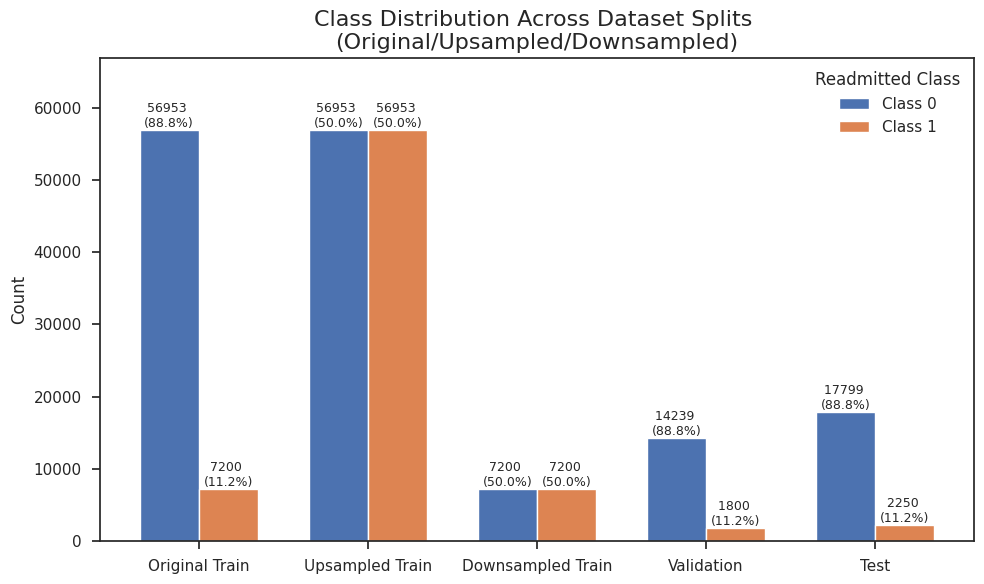

In [ ]:
# Raw counts for each dataset
train_counts = y_train_onehot.value_counts()
val_counts = y_val_onehot.value_counts()
test_counts = y_test_onehot.value_counts()
train_up_counts = y_train_up_onehot.value_counts()
train_down_counts = y_train_down_onehot.value_counts()

# Dataset groups and labels
splits = ['Original Train', 'Upsampled Train', 'Downsampled Train', 'Validation', 'Test']
datasets = [train_counts, train_up_counts, train_down_counts, val_counts, test_counts]
totals = [
    train_counts.sum(),         # Original Train
    train_up_counts.sum(),      # Upsampled Train
    train_down_counts.sum(),    # Downsampled Train
    val_counts.sum(),           # Validation
    test_counts.sum()           # Test
]
x = np.arange(len(splits))
bar_width = 0.35

sns.set(style="ticks")

fig, ax = plt.subplots(figsize=(10, 6))

offsets = {
    0: -bar_width / 2,
    1: bar_width / 2
}

classes = sorted(y_test_onehot.unique())

# Plot bars for each class across all datasets
for cls in classes:
    heights = [ds.get(cls, 0) for ds in datasets]
    positions = x + offsets[cls]
    ax.bar(positions, heights, width=bar_width, label=f'Class {cls}')

    # Add text: count (percentage)
    for i, count in enumerate(heights):
        perc = count / totals[i] * 100
        ax.text(positions[i], count + 20, f"{count} \n({perc:.1f}%)",
                ha='center', va='bottom', fontsize=9)

# Labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(splits, rotation=0)
ax.set_ylabel("Count")
ax.set_title("Class Distribution Across Dataset Splits \n(Original/Upsampled/Downsampled)", size = 16)
ax.set_ylim(0, max(max(train_counts), max(test_counts), max(train_up_counts), max(train_down_counts)) + 10000)
ax.legend(title="Readmitted Class")

plt.tight_layout()
plt.show()


## 3.4 Feature Subsetting

#### Cramer's V for categorical features

In [172]:
def buildVMatrix(df):
    l = []
    cat_vars = one_hot_cat_list
    v_mat = pd.DataFrame(index=cat_vars, columns=cat_vars)

    for var_one in cat_vars:
        for var_two in cat_vars:
            v = association(pd.crosstab(df[var_one], df[var_two]))
            v_mat.loc[var_one, var_two] = v

            if var_one != var_two and v >= 0.9:
                el = [var_one, var_two]
                el.sort()
                if el[1] not in l:
                    l.append(el[1])

    # Convert v_mat to numeric type for heatmap visualization
    v_mat = v_mat.astype(float)
    return v_mat, l

In [173]:
one_hot_cat_list = diabetic_df_one_hot.iloc[:, 10:].columns.to_list()
v_matrix, vars_to_drop = buildVMatrix(X_train_onehot)

print("Variables to drop due to high association (Cramér's V ≥ 0.9):", vars_to_drop)


Variables to drop due to high association (Cramér's V ≥ 0.9): ['metformin_2', 'repaglinide_2', 'nateglinide_2', 'chlorpropamide_2', 'glimepiride_2', 'glipizide_2', 'glyburide_2', 'pioglitazone_2', 'rosiglitazone_2', 'acarbose_2', 'miglitol_2', 'glyburide-metformin_2']


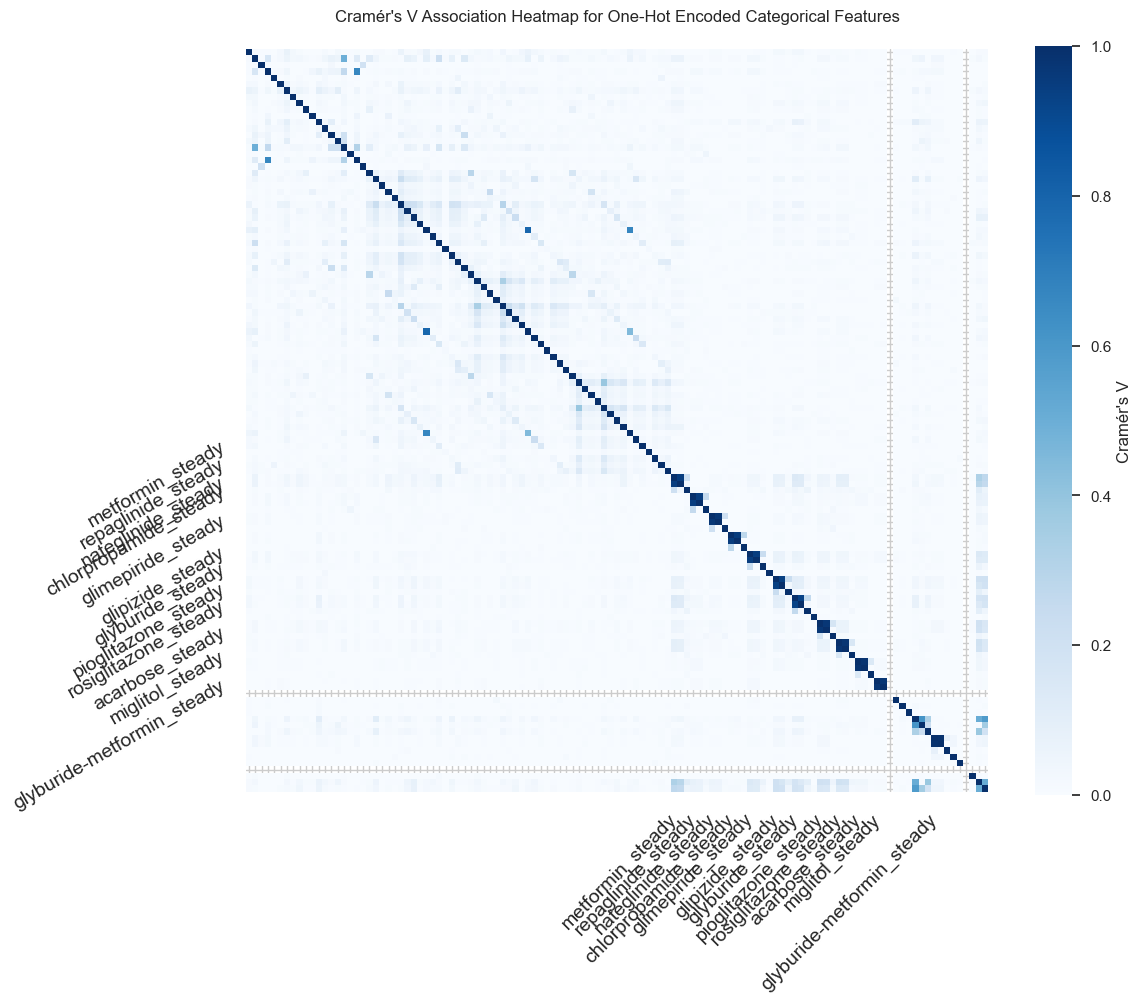

In [ ]:

selected_features = [
    'metformin_2', 'repaglinide_2', 'nateglinide_2', 'chlorpropamide_2',
    'glimepiride_2', 'glipizide_2', 'glyburide_2', 'pioglitazone_2',
    'rosiglitazone_2', 'acarbose_2', 'miglitol_2', 'glyburide-metformin_2'
]

display_features = [feature.replace('_2', '_steady') for feature in selected_features]

plt.figure(figsize=(12, 10))

ax = sns.heatmap(
    v_matrix,
    annot=False,
    cmap="Blues",
    vmin=0, vmax=1,
    square=True,
    cbar_kws={"label": "Cramér's V"},
    xticklabels=True,
    yticklabels=True
)

xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()

new_xticklabels = [
    display_features[selected_features.index(label.get_text())] if label.get_text() in selected_features else ''
    for label in xticklabels
]
ax.set_xticklabels(new_xticklabels, rotation=45, ha="right", fontsize=14)

new_yticklabels = [
    display_features[selected_features.index(label.get_text())] if label.get_text() in selected_features else ''
    for label in yticklabels
]
ax.set_yticklabels(new_yticklabels, rotation=30, fontsize=14)

plt.title("Cramér's V Association Heatmap for One-Hot Encoded Categorical Features", pad=20)
plt.tight_layout()

plt.show()


#### Anova for numerical features

Conclusion: Do not drop any numerical features.

All 9 numerical features are statistically significant (p < 0.001), but the effect size varies a lot. The top 5 features with high Fstat are statistically most discriminative for predicting readmitted.


In [178]:
from sklearn.feature_selection import f_classif
import pandas as pd

num_features = diabetic_df_onehot_unskewed.iloc[:, :9].columns.to_list()

X_numeric = diabetic_df_onehot_unskewed[num_features]
y = diabetic_df_onehot_unskewed['readmitted']

# Run ANOVA F-test
F, p = f_classif(X_numeric, y)

anova_results = pd.DataFrame({
    'Feature': num_features,
    'F-statistic': F,
    'p-value': p
})

# Sort by F-statistic (descending)
anova_results_sorted = anova_results.sort_values(by='F-statistic', ascending=False)

insignificant = anova_results_sorted[anova_results_sorted['p-value'] > 0.01]

if insignificant.empty:
    print("All features are significant (p ≤ 0.01).")
else:
    print("Features with p-value > 0.01 (statistically insignificant):")
    print(insignificant[['Feature', 'p-value']])

All features are significant (p ≤ 0.01).


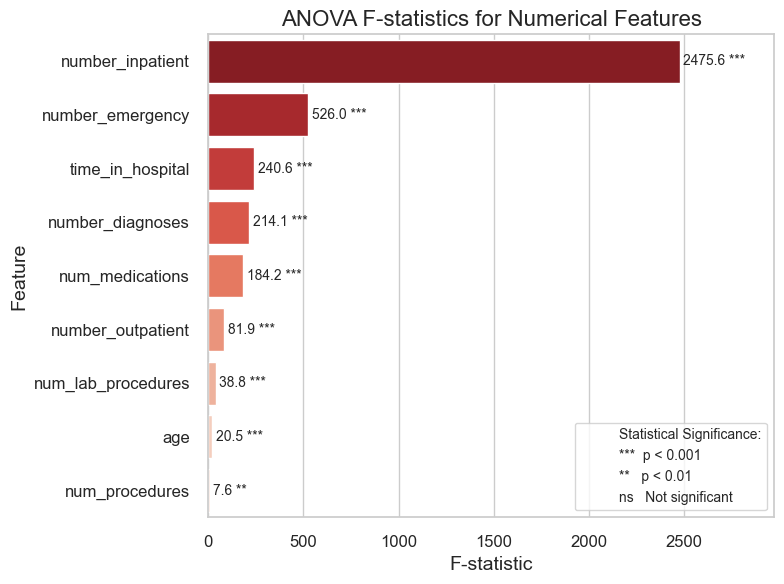

In [ ]:
def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'  # not significant

anova_results_sorted['Significance'] = anova_results_sorted['p-value'].apply(significance_stars)

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=anova_results_sorted,
    y='Feature',
    x='F-statistic',
    palette='Reds_r'
)

plt.title('ANOVA F-statistics for Numerical Features', size=16)
plt.xlabel('F-statistic', size=14)
plt.ylabel('Feature', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim(0, 1.2 * anova_results_sorted['F-statistic'].max())

for bar, (_, row) in zip(ax.patches, anova_results_sorted.iterrows()):
    bar_width = bar.get_width()
    bar_y = bar.get_y() + bar.get_height() / 2
    text = f"{row['F-statistic']:.1f} {row['Significance']}"
    ax.text(bar_width + 20, bar_y, text, va='center', ha='left', fontsize=10)

legend_elements = [
    Line2D([0], [0], color='none', marker='', label='Statistical Significance:'),
    Line2D([0], [0], color='none', marker='', label='***  p < 0.001'),
    Line2D([0], [0], color='none', marker='', label='**   p < 0.01'),
    Line2D([0], [0], color='none', marker='', label='ns   Not significant'),
]

ax.legend(handles=legend_elements, loc='lower right', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()


In [167]:
# Save the dataset after feature processing
diabetic_df_one_hot.to_csv('diabetic_df_processed.csv', index=False)


# 3.5 PCA

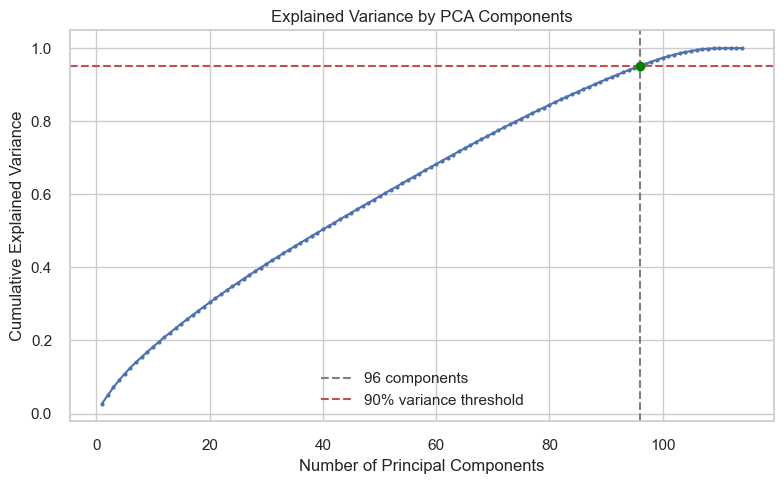

In [125]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_onehot_unskewed_cramer)
X_val_scaled = scaler.transform(X_val_onehot_unskewed_cramer)

# Step 2: Fit PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Step 3: Plot explained variance
explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)
num_components = np.argmax(cum_explained_var >= 0.95) + 1  # +1 for 1-based indexing

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), cum_explained_var, marker='o', markersize = 3)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)

plt.axvline(x=num_components, color='gray', linestyle='--', label=f'{num_components} components')
plt.axhline(y=0.95, color='r', linestyle='--', label='90% variance threshold')
plt.scatter(num_components, cum_explained_var[num_components - 1], color='green', zorder=5)

plt.legend()
plt.tight_layout()
plt.show()



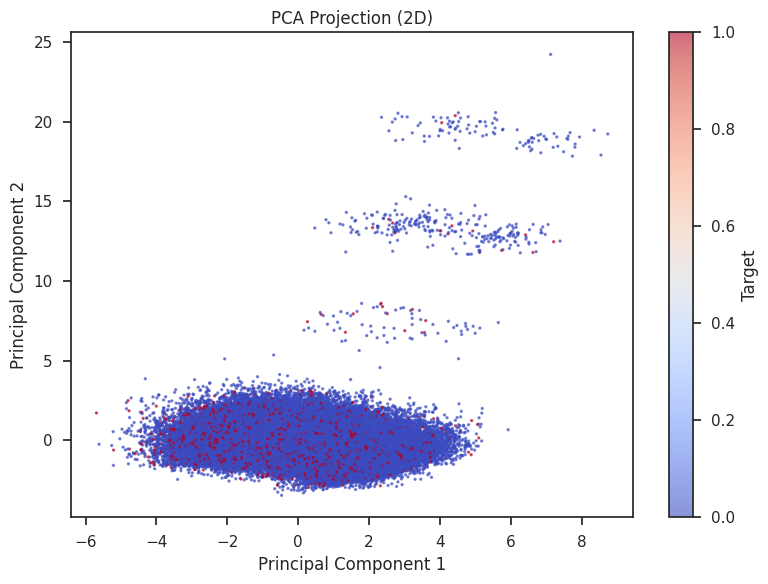

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_onehot_unskewed_cramer, cmap='coolwarm', alpha=0.6, s = 2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection (2D)')
plt.colorbar(label='Target')
plt.tight_layout()
plt.show()

In [ ]:
# Slice the top principal components
X_train_pca = X_train_pca[:, :num_components]
X_val_pca = X_val_pca[:, :num_components]

# Train logistic regression on PCA-reduced data using your function
log_reg_pca, log_reg_pca_metrics = train_log_reg(
    X_train_pca, y_train_onehot_unskewed_cramer,
    X_val_pca, y_val_onehot_unskewed_cramer,
    evaluate_model=evaluate_model,
    model_name=f"Logistic Regression, (One Hot, Unskewed + Cramer, Downsampled, PCA={num_components})"
)

log_reg_pca_metrics

{'Model': 'Logistic Regression, (One Hot, Unskewed + Cramer, Downsampled, PCA=96)',
 'Accuracy': 0.6674356256624477,
 'Precision': 0.17825928623452295,
 'Sensitivity': 0.5438888888888889,
 'Specificity': 0.6830535852236814,
 'F1 Score': 0.2685134393856281,
 'AUROC': 0.6531620120014671,
 'AUPRC': 0.20555666757536303,
 'Threshold': 0.11394121244605734}